<a href="https://colab.research.google.com/github/yuanfeiwo/test-firstrepository/blob/master/Module4_ML_in_Finance_Module_4_Case_study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Market Clustering
## Understanding the relationship between stocks

In [1]:
# Install this if you don't have yfinance
!pip install yfinance

     |████████████████████████████████| 5.5MB 6.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22617 sha256=e2544f1af8b2bc0a8f30f2c20bcbfecc861de7bbc7cfe73d158b3a6defc762ad
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# Acknowledgement: Affinity Propogation Code modified from original code:
# See: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

import datetime
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection

from sklearn import cluster, covariance, manifold

###############################################################################
# Retrieve the data from Internet

d1 = datetime.datetime(2019, 05, 1)
d2 = datetime.datetime(2019, 12, 31)

symbol_dict = {
'MMM':'3M',
'AXP':'American Express',
'AAPL':'Apple',
'BA':'Boeing',
'CAT':'Caterpillar',
'CVX':'Chevron',
'CSCO':'Cisco',
'KO':'Coca-Cola',
'DIS':'Disney',
'DOW':'Dow',
'XOM':'ExxonMobil',
'GS':'Goldman Sachs',
'HD':'Home Depot',
'IBM':'IBM',
'INTC':'Intel',
'JNJ':'Johnson & Johnson',
'JPM':'JP Morgan Chase',
'MCD':'McDonalds',
'MRK':'Merck',
'MSFT':'Microsoft',
'NKE':'Nike',
'PFE':'Pfizer',
'PG':'Procter & Gamble',
'RTX':'Raytheon Technologies',
'TRV':'Travelers',
'UNH':'UnitedHealth',
'VZ':'Verizon',
'V':'Visa',
'WBA':'Walgreens',
'WMT':'Wal-Mart'}
symbols, names = np.array(list(symbol_dict.items())).T

In [3]:
names

array(['American Express', 'Boeing', 'Chevron', 'Cisco', 'Apple', 'Visa',
       'Caterpillar', 'Walgreens', 'Dow', 'Microsoft', 'IBM',
       'Home Depot', 'Disney', 'Raytheon Technologies',
       'Procter & Gamble', 'Goldman Sachs', 'Intel', 'Wal-Mart', 'Merck',
       'UnitedHealth', 'JP Morgan Chase', 'Verizon', 'ExxonMobil',
       'Travelers', 'Pfizer', 'Nike', 'McDonalds', 'Coca-Cola', '3M',
       'Johnson & Johnson'], dtype='|S21')

In [4]:
tickers = [yf.Ticker(symbol) for symbol in symbols]
quotes= [ticker.history(start = d1, end = d2) for ticker in tickers]

In [5]:
quotes[1].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-05-01,369.664253,372.271731,367.564616,367.974762,2765600,0.0,0
2019-05-02,366.705207,368.804845,364.507906,366.998169,2438800,0.0,0
2019-05-03,367.271596,369.048975,365.455174,367.642700,2953800,0.0,0
2019-05-06,359.263673,363.755939,357.066371,362.896545,4747600,0.0,0
2019-05-07,357.749937,359.097620,346.704839,348.863098,9740300,0.0,0


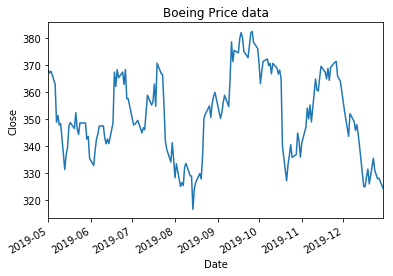

In [6]:
ba = quotes[1]
ba["Close"].plot()
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Boeing Price data")
plt.show()

In [7]:
closes = np.array([q.Close.to_numpy() for q in quotes])
opens = np.array([q.Open.to_numpy() for q in quotes])
df = pd.DataFrame(closes.T, columns = symbol_dict)
df.head()

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,...,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
0,114.172501,367.974762,108.216606,52.995010,51.208199,161.043121,132.048035,50.142490,50.500355,125.228279,...,109.466438,53.035603,70.293938,136.918747,36.145630,84.414024,186.156952,45.936817,174.742844,135.295731
1,114.396912,366.998169,106.903046,52.384781,50.874950,159.391037,129.199631,50.245243,47.414379,123.592903,...,109.704079,53.476635,69.060883,136.555099,36.358410,83.794930,186.578781,45.747738,173.503174,134.657150
2,116.445816,367.642700,107.720566,52.384781,51.507393,160.301193,132.917831,50.516129,47.954201,126.227119,...,110.378967,53.711224,69.221718,137.177124,36.695305,84.217484,189.368698,46.059719,173.944565,135.352905
3,116.436050,362.896545,108.758568,52.051056,50.711975,160.538605,130.719421,50.366669,48.098145,125.492653,...,109.399902,53.401566,68.917908,137.253662,36.925816,82.124336,190.691727,45.823364,171.897263,135.429184
4,115.343307,348.863098,108.639130,50.964077,49.344929,158.490829,127.765892,49.451248,47.639301,122.917198,...,107.612839,53.138824,68.551567,135.607742,36.198826,81.112144,189.867218,45.379025,168.215912,133.408554


In [8]:
returns = df.pct_change()
returns.head().dropna()

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,...,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
1,0.001966,-0.002654,-0.012138,-0.011515,-0.006508,-0.010259,-0.021571,0.002049,-0.061108,-0.013059,...,0.002171,0.008316,-0.017541,-0.002656,0.005887,-0.007334,0.002266,-0.004116,-0.007094,-0.004720
2,0.017910,0.001756,0.007647,0.000000,0.012431,0.005710,0.028779,0.005391,0.011385,0.021314,...,0.006152,0.004387,0.002329,0.004555,0.009266,0.005043,0.014953,0.006820,0.002544,0.005167
3,-0.000084,-0.012910,0.009636,-0.006371,-0.015443,0.001481,-0.016540,-0.002959,0.003002,-0.005819,...,-0.008870,-0.005765,-0.004389,0.000558,0.006282,-0.024854,0.006987,-0.005131,-0.011770,0.000564
4,-0.009385,-0.038671,-0.001098,-0.020883,-0.026957,-0.012756,-0.022594,-0.018175,-0.009540,-0.020523,...,-0.016335,-0.004920,-0.005316,-0.011992,-0.019688,-0.012325,-0.004324,-0.009697,-0.021416,-0.014920


In [9]:
corrMatrix = returns.corr()
corrMatrix

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,...,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,1.000000,0.251210,0.461971,0.502023,0.611511,0.655166,0.519479,0.411833,0.442494,0.685968,...,0.640213,0.309344,0.465060,0.419080,0.332995,0.536849,0.376649,0.318737,0.533293,0.316463
BA,0.251210,1.000000,0.289418,0.249042,0.306988,0.207330,0.366275,0.307981,0.291948,0.333066,...,0.295685,0.067104,0.318573,0.039099,0.076422,0.219214,-0.046062,0.059783,0.274663,0.200787
CVX,0.461971,0.289418,1.000000,0.406950,0.424172,0.254945,0.489543,0.446573,0.556035,0.415256,...,0.543933,0.252557,0.778642,0.169094,0.258467,0.367818,0.018694,0.085547,0.482042,0.161759
CSCO,0.502023,0.249042,0.406950,1.000000,0.545197,0.380652,0.405621,0.373828,0.420072,0.564148,...,0.447661,0.191911,0.444686,0.234960,0.309298,0.496292,0.217324,0.128308,0.398494,0.291078
AAPL,0.611511,0.306988,0.424172,0.545197,1.000000,0.539368,0.569493,0.449252,0.499676,0.634708,...,0.582692,0.128540,0.490827,0.301843,0.306585,0.572730,0.207115,0.223664,0.517309,0.228801
V,0.655166,0.207330,0.254945,0.380652,0.539368,1.000000,0.254998,0.208940,0.277859,0.780124,...,0.376138,0.218746,0.317178,0.561981,0.342060,0.430124,0.424625,0.390552,0.295034,0.209570
CAT,0.519479,0.366275,0.489543,0.405621,0.569493,0.254998,1.000000,0.539847,0.639973,0.414531,...,0.674298,0.173753,0.609340,0.116071,0.334243,0.415721,0.001940,0.086797,0.652322,0.165094
WBA,0.411833,0.307981,0.446573,0.373828,0.449252,0.208940,0.539847,1.000000,0.506862,0.345600,...,0.532445,0.213983,0.487497,0.107231,0.285336,0.359027,-0.008826,0.022764,0.466642,0.205977
DOW,0.442494,0.291948,0.556035,0.420072,0.499676,0.277859,0.639973,0.506862,1.000000,0.419005,...,0.570677,0.188563,0.548620,0.173975,0.295779,0.380585,-0.034161,0.169382,0.547050,0.138144
MSFT,0.685968,0.333066,0.415256,0.564148,0.634708,0.780124,0.414531,0.345600,0.419005,1.000000,...,0.485872,0.196264,0.442052,0.433739,0.345003,0.554239,0.359042,0.342042,0.464483,0.318268


In [10]:

# Limit number of digits:
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,IBM,HD,DIS,RTX,PG,GS,INTC,WMT,MRK,UNH,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,1,0.25,0.46,0.5,0.61,0.66,0.52,0.41,0.44,0.69,0.53,0.46,0.42,0.61,0.33,0.66,0.55,0.48,0.35,0.3,0.64,0.31,0.47,0.42,0.33,0.54,0.38,0.32,0.53,0.32
BA,0.25,1,0.29,0.25,0.31,0.21,0.37,0.31,0.29,0.33,0.26,0.24,0.11,0.4,0.1,0.34,0.26,0.2,0.073,0.12,0.3,0.067,0.32,0.039,0.076,0.22,-0.046,0.06,0.27,0.2
CVX,0.46,0.29,1,0.41,0.42,0.25,0.49,0.45,0.56,0.42,0.44,0.28,0.28,0.47,0.033,0.55,0.38,0.26,0.12,0.17,0.54,0.25,0.78,0.17,0.26,0.37,0.019,0.086,0.48,0.16
CSCO,0.5,0.25,0.41,1,0.55,0.38,0.41,0.37,0.42,0.56,0.5,0.32,0.35,0.47,0.25,0.46,0.48,0.14,0.28,0.24,0.45,0.19,0.44,0.23,0.31,0.5,0.22,0.13,0.4,0.29
AAPL,0.61,0.31,0.42,0.55,1,0.54,0.57,0.45,0.5,0.63,0.54,0.46,0.4,0.59,0.23,0.62,0.65,0.32,0.27,0.16,0.58,0.13,0.49,0.3,0.31,0.57,0.21,0.22,0.52,0.23
V,0.66,0.21,0.25,0.38,0.54,1,0.25,0.21,0.28,0.78,0.46,0.42,0.37,0.55,0.4,0.42,0.46,0.48,0.39,0.16,0.38,0.22,0.32,0.56,0.34,0.43,0.42,0.39,0.3,0.21
CAT,0.52,0.37,0.49,0.41,0.57,0.25,1,0.54,0.64,0.41,0.54,0.4,0.29,0.61,0.046,0.67,0.6,0.3,0.053,0.27,0.67,0.17,0.61,0.12,0.33,0.42,0.0019,0.087,0.65,0.17
WBA,0.41,0.31,0.45,0.37,0.45,0.21,0.54,1,0.51,0.35,0.44,0.34,0.21,0.45,0.061,0.49,0.38,0.18,0.061,0.28,0.53,0.21,0.49,0.11,0.29,0.36,-0.0088,0.023,0.47,0.21
DOW,0.44,0.29,0.56,0.42,0.5,0.28,0.64,0.51,1,0.42,0.52,0.25,0.2,0.52,0.062,0.6,0.47,0.2,0.1,0.2,0.57,0.19,0.55,0.17,0.3,0.38,-0.034,0.17,0.55,0.14
MSFT,0.69,0.33,0.42,0.56,0.63,0.78,0.41,0.35,0.42,1,0.59,0.47,0.4,0.62,0.37,0.52,0.6,0.44,0.39,0.29,0.49,0.2,0.44,0.43,0.35,0.55,0.36,0.34,0.46,0.32


In [11]:
import plotly.figure_factory as ff
figure = ff.create_annotated_heatmap(
z=corrMatrix.values,
y=list(corrMatrix.columns),
x=list(corrMatrix.index),
annotation_text=corrMatrix.round(2).values,
showscale=True, colorscale="Viridis")

In [12]:
distance = 1-corrMatrix.pow(2) # compute distance (Mantegna, 1998 https://arxiv.org/pdf/cond-mat/9802256.pdf)

In [13]:
distance

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,...,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,0.000000,0.936894,0.786582,0.747973,0.626054,0.570758,0.730141,0.830393,0.804199,0.529448,...,0.590127,0.904306,0.783719,0.824372,0.889114,0.711793,0.858136,0.898407,0.715599,0.899851
BA,0.936894,0.000000,0.916237,0.937978,0.905759,0.957014,0.865843,0.905148,0.914766,0.889067,...,0.912570,0.995497,0.898511,0.998471,0.994160,0.951945,0.997878,0.996426,0.924560,0.959685
CVX,0.786582,0.916237,0.000000,0.834392,0.820078,0.935003,0.760348,0.800573,0.690825,0.827563,...,0.704137,0.936215,0.393717,0.971407,0.933195,0.864710,0.999651,0.992682,0.767635,0.973834
CSCO,0.747973,0.937978,0.834392,0.000000,0.702760,0.855104,0.835471,0.860253,0.823540,0.681737,...,0.799599,0.963170,0.802254,0.944794,0.904335,0.753694,0.952770,0.983537,0.841203,0.915273
AAPL,0.626054,0.905759,0.820078,0.702760,0.000000,0.709082,0.675678,0.798172,0.750324,0.597146,...,0.660470,0.983477,0.759089,0.908891,0.906006,0.671981,0.957103,0.949974,0.732391,0.947650
V,0.570758,0.957014,0.935003,0.855104,0.709082,0.000000,0.934976,0.956344,0.922794,0.391407,...,0.858520,0.952150,0.899398,0.684177,0.882995,0.814993,0.819694,0.847469,0.912955,0.956080
CAT,0.730141,0.865843,0.760348,0.835471,0.675678,0.934976,0.000000,0.708565,0.590435,0.828164,...,0.545322,0.969810,0.628705,0.986527,0.888282,0.827176,0.999996,0.992466,0.574477,0.972744
WBA,0.830393,0.905148,0.800573,0.860253,0.798172,0.956344,0.708565,0.000000,0.743091,0.880561,...,0.716502,0.954211,0.762347,0.988502,0.918584,0.871100,0.999922,0.999482,0.782245,0.957574
DOW,0.804199,0.914766,0.690825,0.823540,0.750324,0.922794,0.590435,0.743091,0.000000,0.824435,...,0.674328,0.964444,0.699016,0.969733,0.912515,0.855155,0.998833,0.971310,0.700736,0.980916
MSFT,0.529448,0.889067,0.827563,0.681737,0.597146,0.391407,0.828164,0.880561,0.824435,0.000000,...,0.763928,0.961481,0.804590,0.811871,0.880973,0.692819,0.871089,0.883007,0.784256,0.898706


In [14]:
# Limit number of digits:
distance.style.background_gradient(cmap='viridis').set_precision(2)

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,IBM,HD,DIS,RTX,PG,GS,INTC,WMT,MRK,UNH,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,0,0.94,0.79,0.75,0.63,0.57,0.73,0.83,0.8,0.53,0.72,0.79,0.83,0.63,0.89,0.57,0.7,0.77,0.88,0.91,0.59,0.9,0.78,0.82,0.89,0.71,0.86,0.9,0.72,0.9
BA,0.94,0,0.92,0.94,0.91,0.96,0.87,0.91,0.91,0.89,0.93,0.94,0.99,0.84,0.99,0.88,0.93,0.96,0.99,0.99,0.91,1,0.9,1,0.99,0.95,1,1,0.92,0.96
CVX,0.79,0.92,0,0.83,0.82,0.94,0.76,0.8,0.69,0.83,0.81,0.92,0.92,0.78,1,0.7,0.86,0.93,0.99,0.97,0.7,0.94,0.39,0.97,0.93,0.86,1,0.99,0.77,0.97
CSCO,0.75,0.94,0.83,0,0.7,0.86,0.84,0.86,0.82,0.68,0.75,0.9,0.88,0.78,0.94,0.79,0.77,0.98,0.92,0.94,0.8,0.96,0.8,0.94,0.9,0.75,0.95,0.98,0.84,0.92
AAPL,0.63,0.91,0.82,0.7,0,0.71,0.68,0.8,0.75,0.6,0.71,0.78,0.84,0.65,0.95,0.61,0.58,0.9,0.93,0.98,0.66,0.98,0.76,0.91,0.91,0.67,0.96,0.95,0.73,0.95
V,0.57,0.96,0.94,0.86,0.71,0,0.93,0.96,0.92,0.39,0.78,0.82,0.86,0.7,0.84,0.83,0.79,0.77,0.85,0.97,0.86,0.95,0.9,0.68,0.88,0.81,0.82,0.85,0.91,0.96
CAT,0.73,0.87,0.76,0.84,0.68,0.93,0,0.71,0.59,0.83,0.71,0.84,0.92,0.63,1,0.56,0.63,0.91,1,0.93,0.55,0.97,0.63,0.99,0.89,0.83,1,0.99,0.57,0.97
WBA,0.83,0.91,0.8,0.86,0.8,0.96,0.71,0,0.74,0.88,0.8,0.88,0.96,0.8,1,0.76,0.86,0.97,1,0.92,0.72,0.95,0.76,0.99,0.92,0.87,1,1,0.78,0.96
DOW,0.8,0.91,0.69,0.82,0.75,0.92,0.59,0.74,0,0.82,0.73,0.94,0.96,0.73,1,0.64,0.77,0.96,0.99,0.96,0.67,0.96,0.7,0.97,0.91,0.86,1,0.97,0.7,0.98
MSFT,0.53,0.89,0.83,0.68,0.6,0.39,0.83,0.88,0.82,0,0.65,0.78,0.84,0.61,0.87,0.73,0.64,0.8,0.85,0.92,0.76,0.96,0.8,0.81,0.88,0.69,0.87,0.88,0.78,0.9


In [15]:
## Hierarchical clustering

In [16]:
import scipy.spatial as sci
from scipy.cluster.hierarchy import dendrogram, linkage
conDist = sci.distance.squareform(distance)
L = linkage(conDist, 'average')

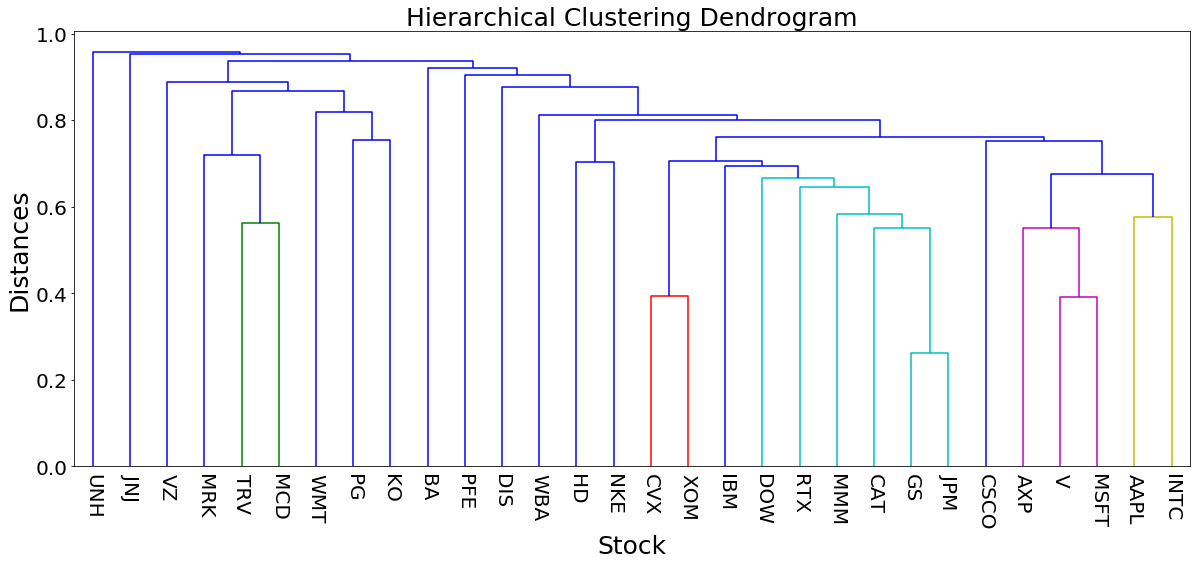

In [17]:
plt.figure(figsize=(20,8))
labelsize=25
ticksize=20
plt.title('Hierarchical Clustering Dendrogram', fontsize=labelsize)
plt.xlabel('Stock', fontsize=labelsize)
plt.ylabel('Distances', fontsize=labelsize)
dendrogram(
    L,
    leaf_font_size=8.,
    labels = symbols
)
plt.yticks(fontsize=ticksize)
plt.xticks(rotation=-90, fontsize=ticksize)
plt.show()

## Affinity propogation

In [18]:
close_prices = closes
open_prices = opens

In [19]:
# The daily variations of the quotes are what carry information
variation = close_prices - open_prices

# #############################################################################
#https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
#https://scikit-learn.org/stable/modules/covariance.html#sparse-inverse-covariance

# Learn a graphical structure from the correlations; Use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others
edge_model = covariance.GraphicalLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=4, assume_centered=False, cv=5, enet_tol=0.0001,
         max_iter=100, mode='cd', n_jobs=None, n_refinements=4, tol=0.0001,
         verbose=False)

In [20]:
type(edge_model.covariance_)
df = pd.DataFrame(data=edge_model.covariance_, index=symbol_dict, columns = symbol_dict)
df

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,...,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,1.000000,0.069357,0.183777,0.347815,0.345611,0.435835,0.241665,0.153978,0.190022,0.476879,...,0.353132,0.119308,0.196193,0.258847,0.116485,0.185239,0.179150,0.158659,0.218264,0.136773
BA,0.069357,1.000000,0.080327,0.062774,0.074010,0.052931,0.103471,0.044973,0.059668,0.067854,...,0.076404,0.021921,0.064975,0.046957,0.020641,0.042786,0.026400,0.025558,0.063284,0.017823
CVX,0.183777,0.080327,1.000000,0.223227,0.188463,0.133126,0.299047,0.188140,0.281422,0.183045,...,0.249809,0.057108,0.566520,0.100568,0.062995,0.116161,0.061424,0.063398,0.307201,0.050556
CSCO,0.347815,0.062774,0.223227,1.000000,0.350193,0.272956,0.239897,0.179190,0.255338,0.406720,...,0.242104,0.094216,0.252863,0.195500,0.132335,0.151634,0.124179,0.128533,0.209807,0.135749
AAPL,0.345611,0.074010,0.188463,0.350193,1.000000,0.275106,0.256891,0.193784,0.190828,0.370079,...,0.277168,0.087425,0.191998,0.171390,0.088795,0.190037,0.113647,0.107482,0.215253,0.087224
V,0.435835,0.052931,0.133126,0.272956,0.275106,1.000000,0.171036,0.109944,0.134524,0.544885,...,0.210571,0.126459,0.140134,0.291363,0.099642,0.171126,0.208250,0.201593,0.147426,0.112244
CAT,0.241665,0.103471,0.299047,0.239897,0.256891,0.171036,1.000000,0.290519,0.402814,0.235521,...,0.345031,0.068232,0.289611,0.121737,0.079075,0.120823,0.060130,0.074652,0.283711,0.061150
WBA,0.153978,0.044973,0.188140,0.179190,0.193784,0.109944,0.290519,1.000000,0.245633,0.151228,...,0.177254,0.042349,0.164867,0.077776,0.065810,0.074202,0.046023,0.048907,0.223822,0.042089
DOW,0.190022,0.059668,0.281422,0.255338,0.190828,0.134524,0.402814,0.245633,1.000000,0.186737,...,0.235669,0.053588,0.234333,0.097066,0.074266,0.091667,0.056297,0.061306,0.301437,0.053665
MSFT,0.476879,0.067854,0.183045,0.406720,0.370079,0.544885,0.235521,0.151228,0.186737,1.000000,...,0.262389,0.128072,0.192020,0.288879,0.123952,0.228824,0.184413,0.175924,0.198496,0.145983


In [21]:
# Limit number of digits:
df.style.background_gradient(cmap='viridis').set_precision(2)

,AXP,BA,CVX,CSCO,AAPL,V,CAT,WBA,DOW,MSFT,IBM,HD,DIS,RTX,PG,GS,INTC,WMT,MRK,UNH,JPM,VZ,XOM,TRV,PFE,NKE,MCD,KO,MMM,JNJ
AXP,1,0.069,0.18,0.35,0.35,0.44,0.24,0.15,0.19,0.48,0.29,0.23,0.15,0.3,0.16,0.37,0.26,0.13,0.15,0.15,0.35,0.12,0.2,0.26,0.12,0.19,0.18,0.16,0.22,0.14
BA,0.069,1,0.08,0.063,0.074,0.053,0.1,0.045,0.06,0.068,0.057,0.052,0.034,0.15,0.026,0.078,0.066,0.019,0.025,0.023,0.076,0.022,0.065,0.047,0.021,0.043,0.026,0.026,0.063,0.018
CVX,0.18,0.08,1,0.22,0.19,0.13,0.3,0.19,0.28,0.18,0.2,0.11,0.071,0.18,0.065,0.25,0.25,0.058,0.06,0.071,0.25,0.057,0.57,0.1,0.063,0.12,0.061,0.063,0.31,0.051
CSCO,0.35,0.063,0.22,1,0.35,0.27,0.24,0.18,0.26,0.41,0.35,0.16,0.15,0.21,0.14,0.26,0.28,0.087,0.12,0.18,0.24,0.094,0.25,0.2,0.13,0.15,0.12,0.13,0.21,0.14
AAPL,0.35,0.074,0.19,0.35,1,0.28,0.26,0.19,0.19,0.37,0.23,0.18,0.14,0.23,0.11,0.33,0.39,0.084,0.1,0.12,0.28,0.087,0.19,0.17,0.089,0.19,0.11,0.11,0.22,0.087
V,0.44,0.053,0.13,0.27,0.28,1,0.17,0.11,0.13,0.54,0.2,0.19,0.14,0.24,0.17,0.22,0.22,0.11,0.16,0.12,0.21,0.13,0.14,0.29,0.1,0.17,0.21,0.2,0.15,0.11
CAT,0.24,0.1,0.3,0.24,0.26,0.17,1,0.29,0.4,0.24,0.26,0.14,0.087,0.25,0.073,0.37,0.38,0.057,0.072,0.09,0.35,0.068,0.29,0.12,0.079,0.12,0.06,0.075,0.28,0.061
WBA,0.15,0.045,0.19,0.18,0.19,0.11,0.29,1,0.25,0.15,0.26,0.083,0.055,0.13,0.049,0.19,0.18,0.037,0.05,0.058,0.18,0.042,0.16,0.078,0.066,0.074,0.046,0.049,0.22,0.042
DOW,0.19,0.06,0.28,0.26,0.19,0.13,0.4,0.25,1,0.19,0.27,0.11,0.068,0.16,0.062,0.26,0.23,0.046,0.061,0.076,0.24,0.054,0.23,0.097,0.074,0.092,0.056,0.061,0.3,0.054
MSFT,0.48,0.068,0.18,0.41,0.37,0.54,0.24,0.15,0.19,1,0.28,0.24,0.15,0.29,0.17,0.28,0.34,0.11,0.17,0.18,0.26,0.13,0.19,0.29,0.12,0.23,0.18,0.18,0.2,0.15


In [22]:
# #############################################################################
# Cluster using affinity propagation
# https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Boeing
Cluster 2: Caterpillar, Walgreens, Dow, Intel
Cluster 3: American Express, Cisco, Apple, Visa, Microsoft, IBM, Raytheon Technologies, UnitedHealth, Johnson & Johnson
Cluster 4: Home Depot, Disney, Nike
Cluster 5: Goldman Sachs, JP Morgan Chase, 3M
Cluster 6: Chevron, ExxonMobil
Cluster 7: Procter & Gamble, Wal-Mart, Merck, Verizon, Travelers, Pfizer, McDonalds, Coca-Cola


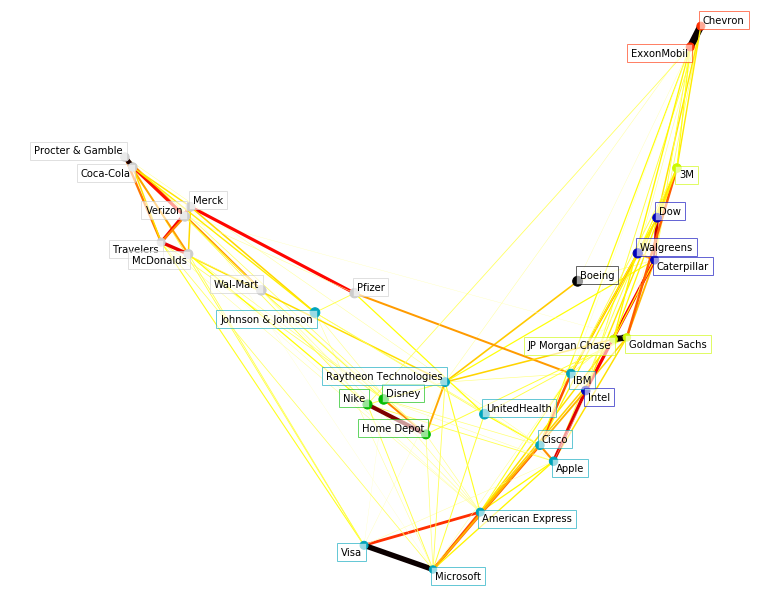

In [23]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()